In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score as acc, r2_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [4]:
# import models and model selections
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
users_data = pd.read_csv("users_data.csv")
users_data.shape

(3214, 5)

In [3]:
users_data.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

In [4]:
users_data.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
users_data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

### There are no missed values

In [6]:
users_data.duplicated().sum()

0

### There are no duplicated rows

## Splitting raw data by samples

In [7]:
features = users_data.drop(['is_ultra'], axis=1)
target = users_data['is_ultra']
features.shape, target.shape

((3214, 4), (3214,))

In [8]:
target.value_counts() / target.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

### There is class disbalance. Let's solve it.
### Decided to use upsampling

In [9]:
def upsampling(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)

    return features_upsampled, target_upsampled

In [10]:
features, target = upsampling(features, target, 2)

In [11]:
target.value_counts() / target.shape[0]

0    0.530841
1    0.469159
Name: is_ultra, dtype: float64

In [12]:
train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size=0.20,
                                                                              random_state=42, stratify=target)
train_features, test_features, train_target, test_target = train_test_split(train_features, train_target,
                                                                            test_size=0.25,
                                                                            random_state=42, stratify=train_target)

In [13]:
print("TRAIN sample shape: {:2.2%}".format(train_features.shape[0] / features.shape[0]))
print("VALID sample shape: {:2.2%}".format(valid_features.shape[0] / features.shape[0]))
print("TEST sample shape: {:2.2%}".format(test_features.shape[0] / features.shape[0]))

TRAIN sample shape: 59.99%
VALID sample shape: 20.00%
TEST sample shape: 20.00%


In [17]:
print("Train shapes:", train_features.shape, train_target.shape)
print("Valid shapes:", valid_features.shape, valid_target.shape)
print("Test shapes:", test_features.shape, test_target.shape)

Train shapes: (2519, 4) (2519,)
Valid shapes: (840, 4) (840,)
Test shapes: (840, 4) (840,)


## Best algorithm searching

### LogisticRegression

In [30]:
scores_solvers_with_l2 = {}
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    logreg = LogisticRegression(random_state=42, solver=solver, penalty='l2')
    logreg.fit(X=train_features, y=train_target)
    print("=======Solver: {}=======".format(solver))
    print("Accuracy TRAIN:", acc(train_target, logreg.predict(train_features)))
    accuracy = acc(valid_target, logreg.predict(valid_features))
    print("Accuracy VALID:", accuracy)
    print("Recall TRAIN:", recall_score(train_target, logreg.predict(train_features)))
    recall = recall_score(valid_target, logreg.predict(valid_features))
    print("Recall VALID:", recall)
    print("Precision TRAIN:", precision_score(train_target, logreg.predict(train_features)))
    precision = precision_score(valid_target, logreg.predict(valid_features))
    print("Precision VALID:", precision)
    print("==========================================\n")
    scores_solvers_with_l2[solver] = {'Accuracy': accuracy, 'Recall': recall, "Precision": precision}

/Users/19929611/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/19929611/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/19929611/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/19929611/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/19929611/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  w

=======Solver: newton-cg=======
Accuracy TRAIN: 0.6530369194124652
Accuracy VALID: 0.6261904761904762
Recall TRAIN: 0.5414551607445008
Recall VALID: 0.5076142131979695
Precision TRAIN: 0.6584362139917695
Precision VALID: 0.625

=======Solver: lbfgs=======
Accuracy TRAIN: 0.5037713378324732
Accuracy VALID: 0.4988095238095238
Recall TRAIN: 0.7038917089678511
Recall VALID: 0.6903553299492385
Precision TRAIN: 0.48036951501154734
Precision VALID: 0.4763572679509632

=======Solver: liblinear=======
Accuracy TRAIN: 0.6526399364827312
Accuracy VALID: 0.6261904761904762
Recall TRAIN: 0.5414551607445008
Recall VALID: 0.5076142131979695
Precision TRAIN: 0.65775950668037
Precision VALID: 0.625

=======Solver: sag=======
Accuracy TRAIN: 0.4644700277888051
Accuracy VALID: 0.44761904761904764
Recall TRAIN: 0.7580372250423012
Recall VALID: 0.7309644670050761
Precision TRAIN: 0.45737621235324144
Precision VALID: 0.4458204334365325

=======Solver: saga=======
Accuracy TRAIN: 0.4585152838427948
Accuracy 

/Users/19929611/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [31]:
scores_solvers_with_l1 = {}
for solver in ['liblinear', 'saga']:
    logreg = LogisticRegression(random_state=42, solver=solver, penalty='l1')
    logreg.fit(X=train_features, y=train_target)
    print("=======Solver: {}=======".format(solver))
    print("Accuracy TRAIN:", acc(train_target, logreg.predict(train_features)))
    accuracy = acc(valid_target, logreg.predict(valid_features))
    print("Accuracy VALID:", accuracy)
    print("Recall TRAIN:", recall_score(train_target, logreg.predict(train_features)))
    recall = recall_score(valid_target, logreg.predict(valid_features))
    print("Recall VALID:", recall)
    print("Precision TRAIN:", precision_score(train_target, logreg.predict(train_features)))
    precision = precision_score(valid_target, logreg.predict(valid_features))
    print("Precision VALID:", precision)
    print("==========================================\n")
    scores_solvers_with_l1[solver] = {'Accuracy': accuracy, 'Recall': recall, "Precision": precision}

=======Solver: liblinear=======
Accuracy TRAIN: 0.6530369194124652
Accuracy VALID: 0.6273809523809524
Recall TRAIN: 0.5423011844331641
Recall VALID: 0.5076142131979695
Precision TRAIN: 0.6581108829568788
Precision VALID: 0.6269592476489029

=======Solver: saga=======
Accuracy TRAIN: 0.4585152838427948
Accuracy VALID: 0.4369047619047619
Recall TRAIN: 0.7538071065989848
Recall VALID: 0.7208121827411168
Precision TRAIN: 0.45366598778004075
Precision VALID: 0.43894899536321486



/Users/19929611/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
scores_solvers_with_l1, scores_solvers_with_l2

({'liblinear': {'Accuracy': 0.6273809523809524,
   'Recall': 0.5076142131979695,
   'Precision': 0.6269592476489029},
  'saga': {'Accuracy': 0.4369047619047619,
   'Recall': 0.7208121827411168,
   'Precision': 0.43894899536321486}},
 {'newton-cg': {'Accuracy': 0.6261904761904762,
   'Recall': 0.5076142131979695,
   'Precision': 0.625},
  'lbfgs': {'Accuracy': 0.4988095238095238,
   'Recall': 0.6903553299492385,
   'Precision': 0.4763572679509632},
  'liblinear': {'Accuracy': 0.6261904761904762,
   'Recall': 0.5076142131979695,
   'Precision': 0.625},
  'sag': {'Accuracy': 0.44761904761904764,
   'Recall': 0.7309644670050761,
   'Precision': 0.4458204334365325},
  'saga': {'Accuracy': 0.4369047619047619,
   'Recall': 0.7208121827411168,
   'Precision': 0.43894899536321486}})

In [37]:
scores_solvers_with_l1 = pd.DataFrame(scores_solvers_with_l1).T
scores_solvers_with_l1

,Accuracy,Recall,Precision
liblinear,0.627381,0.507614,0.626959
saga,0.436905,0.720812,0.438949


In [38]:
scores_solvers_with_l2 = pd.DataFrame(scores_solvers_with_l2).T
scores_solvers_with_l2

,Accuracy,Recall,Precision
newton-cg,0.626190,0.507614,0.625000
lbfgs,0.498810,0.690355,0.476357
liblinear,0.626190,0.507614,0.625000
sag,0.447619,0.730964,0.445820
saga,0.436905,0.720812,0.438949


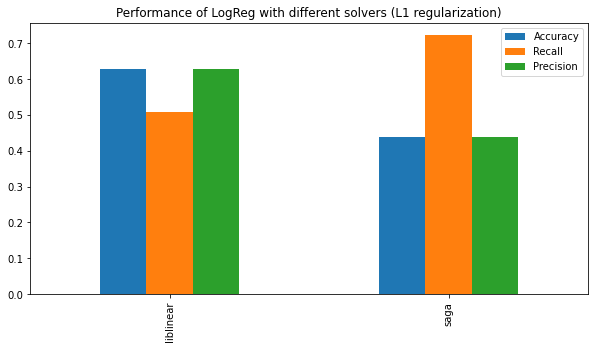

In [42]:
axes = scores_solvers_with_l1.plot(kind='bar', title="Performance of LogReg with different solvers (L1 regularization)",
                                   figsize=(10, 5))

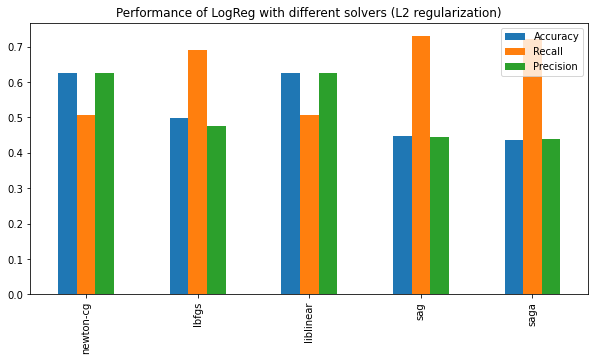

In [43]:
axes = scores_solvers_with_l2.plot(kind='bar', title="Performance of LogReg with different solvers (L2 regularization)",
                                   figsize=(10, 5))

### liblinear ✅ (or newton-cg)

In [44]:
logreg = LogisticRegression(random_state=42, solver='liblinear', penalty='l1')
logreg.fit(train_features, train_target)
logreg.coef_

array([[1.01334045e-03, 1.50508262e-03, 7.70145802e-03, 3.65481496e-05]])

In [45]:
train_features.describe()

,calls,minutes,messages,mb_used
count,2519.000000,2519.000000,2519.000000,2519.000000
mean,65.931719,458.579274,41.129019,17829.071592
std,36.731299,259.422897,39.956057,8400.414885
min,0.000000,0.000000,0.000000,0.000000
25%,41.000000,280.105000,8.000000,12407.520000
50%,64.000000,434.590000,31.000000,17289.880000
75%,86.000000,602.835000,62.000000,22361.110000
max,244.000000,1632.060000,224.000000,49745.730000


### Coefficients of logistic regression is OK (small coef of the 4th feature compensates for the scale)

### Let's find best hyperparameters

In [124]:
logreg = LogisticRegression(random_state=42, solver='liblinear')
parameters = {"C": np.linspace(1, 5, 20), "penalty": ['l1', 'l2'], "class_weight": ["balanced", None]}
gridSearchCV = GridSearchCV(logreg, parameters, scoring='r2', cv=5)
gridSearchCV.fit(train_features, train_target)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': array([1.        , 1.21052632, 1.42105263, 1.63157895, 1.84210526,
       2.05263158, 2.26315789, 2.47368421, 2.68421053, 2.89473684,
       3.10526316, 3.31578947, 3.52631579, 3.73684211, 3.94736842,
       4.15789474, 4.36842105, 4.57894737, 4.78947368, 5.        ]),
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             scoring='r2')

In [125]:
logreg = gridSearchCV.best_estimator_.fit(train_features, train_target)
gridSearchCV.best_params_, gridSearchCV.best_score_

({'C': 1.631578947368421, 'class_weight': None, 'penalty': 'l2'},
 -0.40905748384315965)

In [126]:
valid_prediction = logreg.predict(valid_features)
valid_prediction_proba = logreg.predict_proba(valid_features)

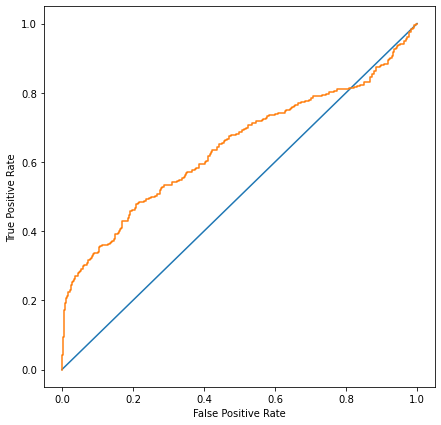

In [127]:
fpr, tpr, thresholds = roc_curve(valid_target, valid_prediction_proba[:, 1])
plt.figure(figsize=(7, 7))
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [128]:
print("Roc auc: ", roc_auc_score(valid_target, valid_prediction))
print("Accuracy: ", acc(valid_target, valid_prediction))
print("F1: ", f1_score(valid_target, valid_prediction))
print("R2: ", r2_score(valid_target, valid_prediction))

Roc auc:  0.6203990348501058
Accuracy:  0.6273809523809524
F1:  0.5610098176718092
R2:  -0.4962099656279164


### R^2 < 0, so it predicts worse than random model, why?
### Shall we look to feature relationship?

In [151]:
colors = {1 : 'green', 0 : 'blue'}

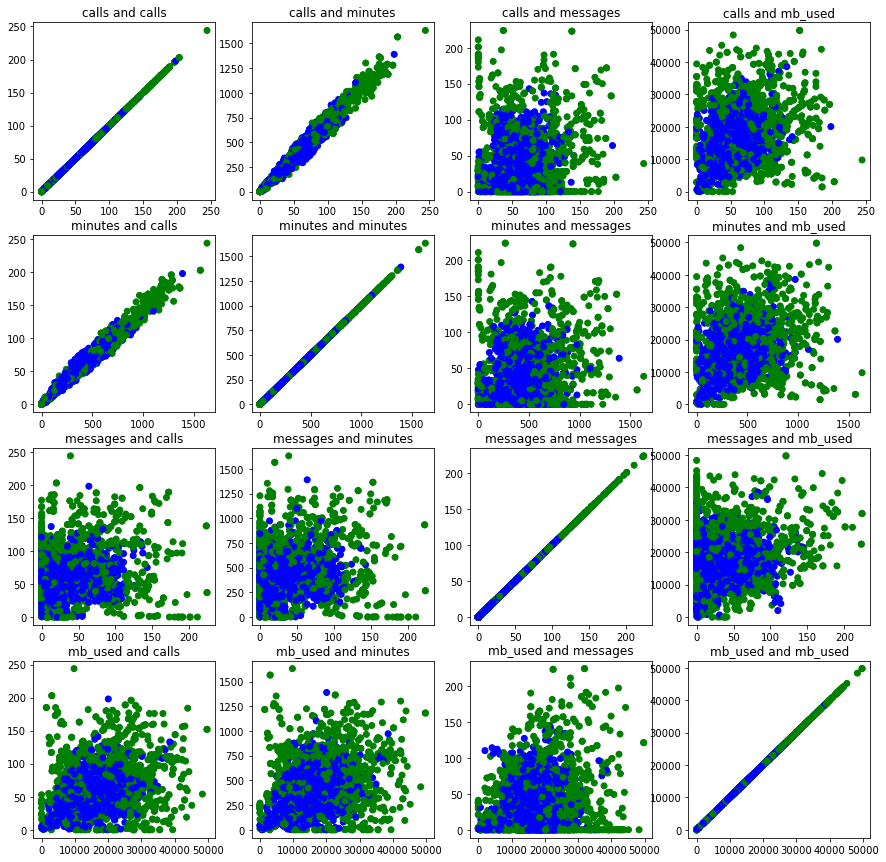

In [153]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i in range(len(train_features.columns)):
    for j in range(len(train_features.columns)):
        axs[i, j].scatter(train_features[train_features.columns[i]],
                          train_features[train_features.columns[j]],
                          c=train_target.map(colors))
        axs[i, j].set_title("{} and {}".format(train_features.columns[i], train_features.columns[j]))
plt.show()

### Such distributions are difficult to predict with linear models
### There is one group inside another, let's try tree family of functions.

In [ ]:
decision_tree = DecisionTreeClassifier()